In [1]:
from collections import namedtuple
import csv
import math
import numpy as np

import matplotlib.pyplot as plt

import nbimporter
import Weather
import SolarPosition
import SplittingGlobal2BeamDiffuseRadiation

Importing Jupyter notebook from Weather.ipynb
Importing Jupyter notebook from SolarPosition.ipynb
Importing Jupyter notebook from SplittingGlobal2BeamDiffuseRadiation.ipynb


# 斜面日射量を計算するモジュール

## 1. Functions  

### 1.1. Isotropic Model  

水平面全天日射量・水平面天空日射量・法線面直達日射量から斜面（開口面）日射量（直達・天空・地表面反射）を計算する。

### 入力値  

$ I_G $ ：水平面全天日射量 [MJ/(m<sup>2</sup>･h)]  
$ I_b $ ：法線面直達日射量 [MJ/(m<sup>2</sup>･h)]  
$ I_d $ ：水平面天空日射量 [MJ/(m<sup>2</sup>･h)]  
$ h $ ：太陽高度角 (°)  
$ A $ ：太陽方位角 (°)  
$ \beta $ ：水平面に対する斜面（開口面）の傾斜角 (°)  
$ A_w $ ：斜面（開口面）の方位角 (°)  
$ \rho $ ：アルベド  

### 出力値

$ I_{T,b} $ ：斜面（開口面）直達日射量 [MJ/(m<sup>2</sup>･h)]  
$ I_{T,d} $ ：斜面（開口面）天空日射量 [MJ/(m<sup>2</sup>･h)]  
$ I_{T,r} $ ：斜面（開口面）地表面反射日射量 [MJ/(m<sup>2</sup>･h)]  
$ \phi $ ：直達日射の入射角 (°)  

### 計算方法

#### データ構造と値の範囲

$ I_G $・$ I_d $・$ I_b $・$ h $・$ A $・$ \beta $・$ A_w $・$ \rho $の組み合わせを1つの変数（タプル）で表し"st_tuple"とする。  
$ h $は0°以上、90°以下の値をとる。  
$ \rho $は0.0以上、1.0以下の値をとる。

In [2]:
def st_input():
    return namedtuple('st_tuple', 'st_ig st_ib st_id st_h st_A st_Bw st_Aw st_rho')

#st_ig：水平面全天日射量 [MJ/(m2･h)]  
#st_ib：法線面直達日射量 [MJ/(m2･h)]  
#st_id：水平面天空日射量 [MJ/(m2･h)]  
#st_h：太陽高度角 (°) 
#st_A：太陽方位角 (°)  
#st_Bw：水平面に対する斜面（開口面）の傾斜角 (°)  
#st_Aw：斜面（開口面）の方位角 (°)  
#st_rho：アルベド

#### 斜面（開口面）日射量（Isotropic model）の計算

（参考：拡張アメダス気象データ1981-2000解説書 8.2.2　斜面日射量の計算）  

斜面（開口面）日射量（Isotropic model）の計算方法を以下に示す。  

$ \begin{align}I_{T,b} = I_b ･ \cos \phi\end{align}$ ････････････････････････････････････････････ (3.4-a)  

$ \begin{align}I_{T,d} = I_d ･ \frac{1 + \cos\beta}{2}\end{align}$ ････････････････････････････････････････ (3.4-b)  

$ \begin{align}I_{T,r} = I_G ･ \frac{1 - \cos\beta}{2} ･ \rho\end{align}$ ･･････････････････････････････････････ (3.4-c)  

$ \begin{align}\cos \phi = \sin h ･ \cos \beta + \cos h ･ \sin \beta ･ \cos (A-A_w)\end{align}$ ･････････････ (3.4-d)  


In [3]:
#斜面（開口面）日射量（Isotropic model）の計算
#斜面（開口面）直達日射量、斜面（開口面）天空日射量、斜面（開口面）地表面反射日射量、直達日射の入射角
def solor_tilt(L):

    if 0. < L.st_h and L.st_h < 3.:
        st_sinh =  math.sin(math.radians(3.)) #太陽高度角の補正
        st_cosh =  math.cos(math.radians(3.)) #太陽高度角の補正
    elif 3. < L.st_h and L.st_h < 90.:
        st_sinh =  math.sin(math.radians(L.st_h))
        st_cosh =  math.cos(math.radians(L.st_h))
    else:
        st_sinh =  0.
        st_cosh =  1.
            
    if st_sinh > 0. and L.st_ig > 0.:
        st_cosphi = abs(st_sinh * math.cos(math.radians(L.st_Bw)) + st_cosh * math.sin(math.radians(L.st_Bw)) * \
                    math.cos(math.radians(L.st_A - L.st_Aw)))
        r_st_ib = L.st_ib * st_cosphi
        r_st_id = L.st_id * (1 + math.cos(math.radians(L.st_Bw))) / 2
        r_st_ir = L.st_ig * (1 - math.cos(math.radians(L.st_Bw))) / 2 * L.st_rho
        r_st_phi = math.degrees(math.acos(st_cosphi))
    else:
        r_st_ib = 0.
        r_st_id = 0.
        r_st_ir = 0.
        r_st_phi = 90.
        
    return r_st_ib, r_st_id, r_st_ir, r_st_phi

#### Example

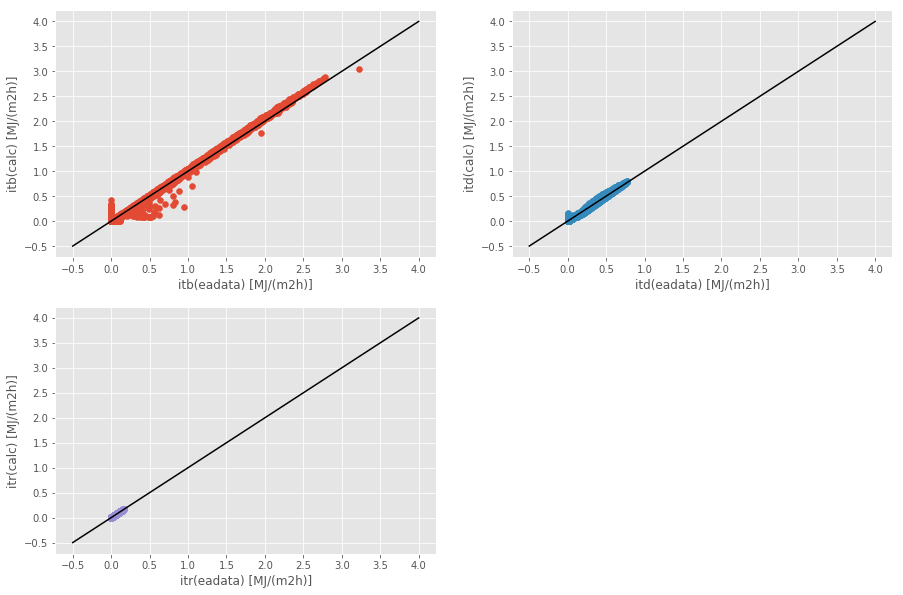

In [4]:
if __name__ == '__main__':

    location = '3639999'               #東京ID
    year = 1995                        #西暦年
    lat = 35. + 41.2 / 60.             #計算対象地点の緯度 (°)  
    lon = 139. + 45.9 / 60.            #計算対象地点の経度 (°)  
    Bw = 90.                           #水平面に対する斜面（開口面）の傾斜角 (°) 
    Aw = 0.                            #斜面（開口面）の方位角 (°)
    rho = 0.1                          #アルベド

    #気象データ読込
    ig = Weather.weather_input(location)[4]                                        #水平面全天日射量

    st_result = np.empty((7,8760))

    for i in range(0, 8760):
        sp_in = SolarPosition.sp_input()(year, int((i + 1.) / 24.) + 1., ((i + 1.) / 24. - int((i + 1.) / 24.)) * 24., lat, lon)
        sp_h = SolarPosition.solar_position(sp_in)[0]                                    #太陽高度角
        sp_A = SolarPosition.solar_position(sp_in)[1]                                    #太陽方位角

        dbd_in = SplittingGlobal2BeamDiffuseRadiation.dbd_input()(ig[i], sp_h)
        dbd_ib = SplittingGlobal2BeamDiffuseRadiation.division_beam_diffuse(dbd_in)[0]                          #法線面直達日射量
        dbd_id = SplittingGlobal2BeamDiffuseRadiation.division_beam_diffuse(dbd_in)[1]                          #水平面天空日射量

        st_in = st_input()(ig[i], dbd_ib, dbd_id, sp_h, sp_A, Bw, Aw, rho)
        st_result[0][i] = i + 1.                                           #年通算時間
        st_result[1][i] = int((i + 1.) / 24.) + 1.                         #年通算日
        st_result[2][i] = ((i + 1.) / 24. - int((i + 1.) / 24.)) * 24.     #時刻
        st_result[3][i] = solor_tilt(st_in)[0]                             #斜面（開口面）直達日射量
        st_result[4][i] = solor_tilt(st_in)[1]                             #斜面（開口面）天空日射量
        st_result[5][i] = solor_tilt(st_in)[2]                             #斜面（開口面）地表面反射日射量
        st_result[6][i] = solor_tilt(st_in)[3]                             #直達日射の入射角

    #np.savetxt(location + '_out_st.csv', np.transpose(st_result), fmt='%.10f', delimiter=',')

    #確認用気象データ読込
    itb_ea = Weather.weather_confirm_input(location)[2]                            #斜面（開口面）直達日射量
    itd_ea = Weather.weather_confirm_input(location)[3]                            #斜面（開口面）天空日射量
    itr_ea = Weather.weather_confirm_input(location)[4]                            #斜面（開口面）地表面反射日射量

    #グラフの描画
    graph_num = 3
    ax = np.empty(graph_num, dtype = np.object)
    fig = plt.figure(figsize = (15, 5 * ((graph_num + 1) // 2)))
    plt.style.use('ggplot')

    gpc = ['C0', 'C1', 'C2']
    gxd = [[itb_ea[0:8760], [-0.5,4.]], [itd_ea[0:8760], [-0.5,4.]], [itr_ea[0:8760], [-0.5,4.]]]
    gyd = [[st_result[3][0:8760], [-0.5,4.]], [st_result[4][0:8760], [-0.5,4.]], [st_result[5][0:8760], [-0.5,4.]]]
    gxl = ['itb(eadata) [MJ/(m2h)]','itd(eadata) [MJ/(m2h)]','itr(eadata) [MJ/(m2h)]']
    gyl = ['itb(calc) [MJ/(m2h)]', 'itd(calc) [MJ/(m2h)]', 'itr(calc) [MJ/(m2h)]']
    gxt = [[0.5 * (i-1) for i in range(10)], [0.5 * (i-1) for i in range(10)], [0.5 * (i-1) for i in range(10)]]
    gyt = [[0.5 * (i-1) for i in range(10)], [0.5 * (i-1) for i in range(10)], [0.5 * (i-1) for i in range(10)]]

    for i in range(graph_num):   
        ax[i] = fig.add_subplot((graph_num + 1) // 2, 2, i + 1)
        ax[i].scatter(gxd[i][0], gyd[i][0], color = gpc[i])
        ax[i].plot(gxd[i][1], gyd[i][1], color = (0,0,0))
        ax[i].set_xticks(gxt[i])
        ax[i].set_yticks(gyt[i])
        ax[i].set_xlabel(gxl[i], fontsize = 12)
        ax[i].set_ylabel(gyl[i], fontsize = 12)

    plt.show()